In [2]:
# declare a list tasks whose products you want to use as inputs
upstream = None


In [1]:
# Imports and Setup
import pandas as pd
import numpy as np
from pathlib import Path
import sys
import logging
import json
import torch
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
import importlib

# Add project root to path
sys.path.append(str(Path.cwd().parent))

# Import and reload modules to get fresh changes
from src.models.predictor import TrollPredictor
from src.data_tools.czech_data_tools import load_czech_media_data
from src.data_tools.czech_data_tools import export_comments_by_prediction
import src.models.predictor

# Configure matplotlib and seaborn
plt.style.use('default')
sns.set_theme()

In [3]:
DATA_DIR = Path('data')

# Initialize predictor with model
model_path = "../checkpoints/best_model.pt"

predictor = TrollPredictor(
    model_path=model_path,
    comments_per_user=10,
    max_length=96
)

INFO:src.models.predictor:Loaded model weights from ../checkpoints/best_model.pt


In [10]:
DATA_DIR = Path('../data')
czech_comments = load_czech_media_data(str(DATA_DIR / 'MediaSource'))
print(f"Loaded {len(czech_comments)} comments from {czech_comments['author'].nunique()} unique authors")

# PROCESSED_DIR = DATA_DIR / 'processed'
# PROCESSED_DIR.mkdir(exist_ok=True)
# czech_media_parquet = PROCESSED_DIR / 'czech_media_comments.parquet'

# if czech_media_parquet.exists():
#     print(f"Loading preprocessed data from {czech_media_parquet}...")
#     czech_comments = pd.read_parquet(czech_media_parquet)
# else:
#     print("Preprocessed data not found. Loading and processing from source...")
#     czech_comments = load_czech_media_data(str(DATA_DIR / 'MediaSource'))
#     # Save processed data
#     czech_comments.to_parquet(czech_media_parquet)
#     print(f"Preprocessed data saved to {czech_media_parquet}")

# #print(f"Loaded {len(czech_comments)} comments from {czech_comments['author'].nunique()} unique authors")

Loading files: 100%|██████████| 124/124 [00:17<00:00,  7.18it/s]


Loaded 845551 comments from 66578 unique authors


In [12]:
# Display data info
print("\nDataset columns:", czech_comments.columns.tolist())
print("\nSample of comments:")
print(czech_comments[['text', 'author', 'sentiment']].head())


Dataset columns: ['text', 'raw_text', 'author', 'timestamp', 'article_title', 'url', 'article_id', 'sentiment']

Sample of comments:
                                                text        author   sentiment
0                                   Umí jiného lhát?   Jiří Mraček    Negative
1  Nezávislost Rusku lež věž Ruska bereme ropu pl...  Fiala Václav    Negative
2  Vsak jinak. stěžovali, učit, vlada odklepla, t...   Jana Krejci     Neutral
3  reforma školství stíhá druhou, hlavně dětičky ...   Jiří Flusek     Neutral
4  Frantisek LuftNaštěstí vychází logiky intelekt...   Honza Novak  Ambivalent


In [13]:
# Count original number of authors and comments
total_authors = czech_comments['author'].nunique()
total_comments = len(czech_comments)
print(f"Loaded {total_comments} comments from {total_authors} unique authors")

# Filter authors with at least 5 comments
author_counts = czech_comments['author'].value_counts()
authors_with_min_5 = author_counts[author_counts >= 5].index
czech_comments = czech_comments[czech_comments['author'].isin(authors_with_min_5)]

# Count filtered number of authors and comments
filtered_authors = czech_comments['author'].nunique()
filtered_comments = len(czech_comments)
print(f"Filtered to {filtered_comments} comments from {filtered_authors} authors with at least 5 comments")
print(f"Removed {total_authors - filtered_authors} authors with fewer than 5 comments")

Loaded 845551 comments from 66578 unique authors
Filtered to 775377 comments from 25454 authors with at least 5 comments
Removed 41124 authors with fewer than 5 comments


In [14]:
# Make predictions and save results
output_dir = Path('output')
output_dir.mkdir(exist_ok=True)
cache_file = output_dir / 'results_df.pkl'

# Load cached results if available
# if cache_file.exists():
#     print(f"Loading cached results from {cache_file}...")
#     results_df = pd.read_pickle(cache_file)
# else:
#     print("No cached results found. Please run the prediction step first.")

results = []
for idx, group in tqdm(czech_comments.groupby('author')):
    texts = group['text'].tolist()
    
    # Get prediction
    pred = predictor.predict_batch(texts)
    
    # Store results
    results.append({
        'author': idx,
        'n_comments': len(texts),
        'prediction': pred['prediction'],
        'confidence': pred['confidence'],
        'troll_probability': pred['probabilities'][1]
    })

# Convert to DataFrame and cache it
results_df = pd.DataFrame(results)
results_df.to_pickle(cache_file)
print("results_df saved for future runs.")



100%|██████████| 25454/25454 [05:38<00:00, 75.20it/s]


results_df saved for future runs.


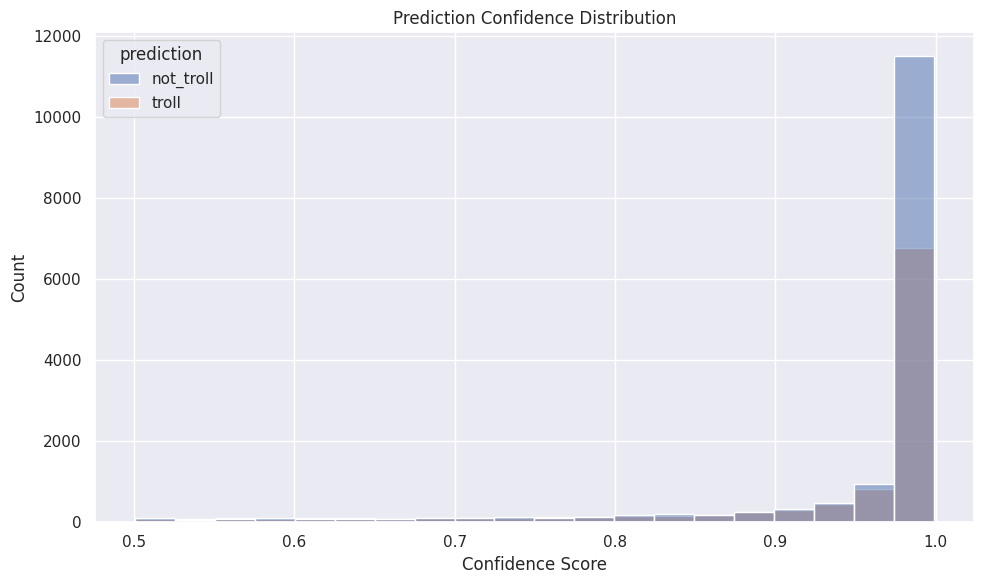

In [15]:
# Cell: Analyze predictions by confidence levels
# Create visualization
plt.figure(figsize=(10, 6))
sns.histplot(
    data=results_df, 
    x='confidence', 
    hue='prediction', 
    bins=20
)
plt.title('Prediction Confidence Distribution')
plt.xlabel('Confidence Score')
plt.ylabel('Count')
plt.tight_layout()
plt.show()




In [20]:
# Print classification counts
prediction_counts = results_df['prediction'].value_counts()
print("\nUser Classification Counts:")
print("-" * 25)
for label, count in prediction_counts.items():
    print(f"{label}: {count:,} users")
print("-" * 25)



User Classification Counts:
-------------------------
not_troll: 15,231 users
troll: 10,223 users
-------------------------


In [17]:
# Save a sample of troll and not_troll classified comments

export_comments_by_prediction(
    predictions_df=results_df,
    comments_df=czech_comments,
    prediction_class='troll',
    min_confidence=0.7,
    max_confidence=1,
    max_authors=50,
    output_file="../output/troll_comments.json"
)

export_comments_by_prediction(
    predictions_df=results_df,
    comments_df=czech_comments,
    prediction_class='not_troll',
    min_confidence=0.8,
    max_authors=50,
    output_file="../output/non_troll_comments.json"
)

Processing troll comments: 100%|██████████| 50/50 [00:03<00:00, 16.57it/s]



Exported 1096 comments from 50 authors
Output saved to: ../output/troll_comments.json


Processing not_troll comments: 100%|██████████| 50/50 [00:02<00:00, 16.81it/s]


Exported 678 comments from 50 authors
Output saved to: ../output/non_troll_comments.json


In [18]:
def explain_author(
    author_name: str, 
    predictor_instance: TrollPredictor, 
    comments_df: pd.DataFrame, 
    display_plots: bool = True,
):
    """Interactive function to explain why an author was classified as a troll using multiple methods"""
    
    # Get author's comments
    author_comments = comments_df[comments_df['author'] == author_name]['text'].tolist()
    
    if not author_comments:
        print(f'No comments found for author: {author_name}')
        return
        
    # Get prediction first
    pred = predictor_instance.predict_batch(author_comments)
    
    if pred['prediction'] != 'troll':
        print(f'Author {author_name} is not classified as a troll (confidence: {pred["confidence"]:.3f})')
        return
    
    print(f"\nAnalyzing author: {author_name}")
    print(f"Prediction confidence: {pred['confidence']:.3f}")
    print(f"Troll probability: {pred['probabilities'][1]:.3f}")
    
    # Generate occlusion sensitivity explanation
    print("\n=== Occlusion Sensitivity Analysis ===")
    explanation = predictor_instance.explain_prediction(author_comments)
    
    # Print occlusion sensitivity results
    for i, exp in enumerate(explanation['explanations'], 1):
        print(f"\nComment {i}:")
        print(f"Text: {exp['tweet_text']}")
        print("\nMost influential tokens (Occlusion Sensitivity):")
        
        # Create a table with token contributions
        contrib_data = []
        for contrib in exp['token_contributions']:
            direction = "Supporting" if contrib['contribution'] == 'positive' else "Opposing"
            contrib_data.append([
                contrib['token'],
                f"{contrib['importance']:.4f}",
                direction
            ])
        
        contrib_df = pd.DataFrame(contrib_data, columns=['Token', 'Importance', 'Effect'])
        print(contrib_df.to_string(index=False))
        
        if display_plots:
            img = plt.imread(exp['plot_filename'])
            plt.figure(figsize=(12, 4))
            plt.imshow(img)
            plt.axis('off')
            plt.title(f'Occlusion Sensitivity Analysis - Comment {i}')
            plt.show()
        
        print("-" * 80)


Analyzing author: Vladimír Furrer
Prediction confidence: 0.987
Troll probability: 0.987

=== Occlusion Sensitivity Analysis ===

Generating explanations using occlusion sensitivity...

Processing tweet 1/10
Occlusion analysis for Tweet 1:
Text: …promluvil prodavač nutelly
Plot saved to: importance_tweet_1.png
Top contributing tokens:
  - '[UNK]': 0.0260 (supporting the prediction)

Processing tweet 2/10
Occlusion analysis for Tweet 2:
Text: podívejme se..plyn Slovenska dobrý?
Plot saved to: importance_tweet_2.png
Top contributing tokens:

Processing tweet 3/10
Occlusion analysis for Tweet 3:
Text: jeho..vždyt nyní placená?
Plot saved to: importance_tweet_3.png
Top contributing tokens:

Processing tweet 4/10
Occlusion analysis for Tweet 4:
Text: Počátky demence..
Plot saved to: importance_tweet_4.png
Top contributing tokens:

Processing tweet 5/10
Occlusion analysis for Tweet 5:
Text: pravda…
Plot saved to: importance_tweet_5.png
Top contributing tokens:

Processing tweet 6/10
Occlusio

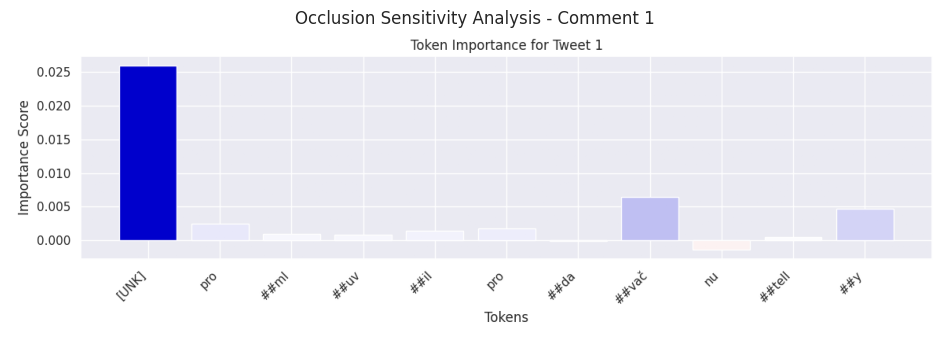

--------------------------------------------------------------------------------

Comment 2:
Text: podívejme se..plyn Slovenska dobrý?

Most influential tokens (Occlusion Sensitivity):
Empty DataFrame
Columns: [Token, Importance, Effect]
Index: []


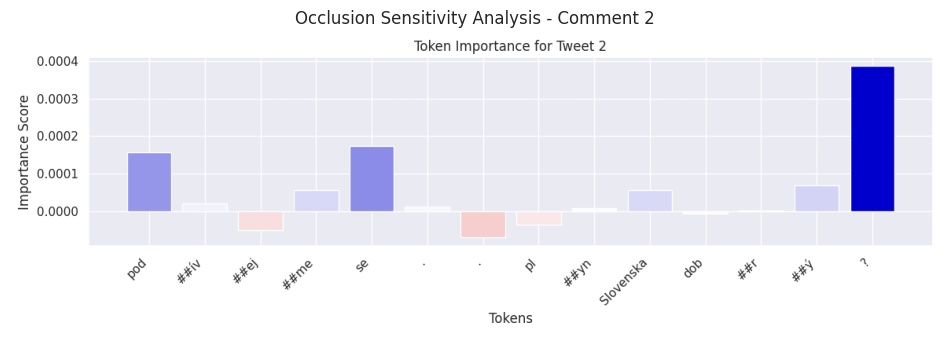

--------------------------------------------------------------------------------

Comment 3:
Text: jeho..vždyt nyní placená?

Most influential tokens (Occlusion Sensitivity):
Empty DataFrame
Columns: [Token, Importance, Effect]
Index: []


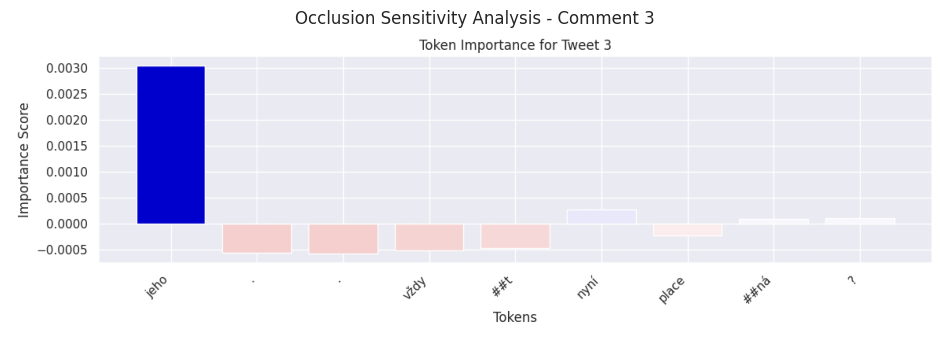

--------------------------------------------------------------------------------

Comment 4:
Text: Počátky demence..

Most influential tokens (Occlusion Sensitivity):
Empty DataFrame
Columns: [Token, Importance, Effect]
Index: []


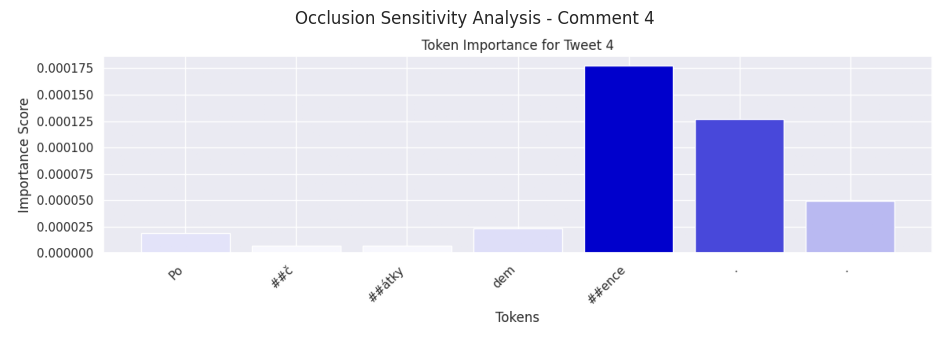

--------------------------------------------------------------------------------

Comment 5:
Text: pravda…

Most influential tokens (Occlusion Sensitivity):
Empty DataFrame
Columns: [Token, Importance, Effect]
Index: []


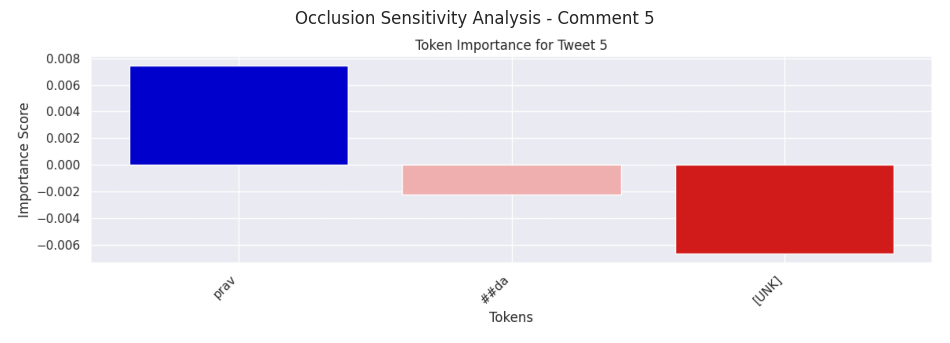

--------------------------------------------------------------------------------

Comment 6:
Text: mimořádný….

Most influential tokens (Occlusion Sensitivity):
Empty DataFrame
Columns: [Token, Importance, Effect]
Index: []


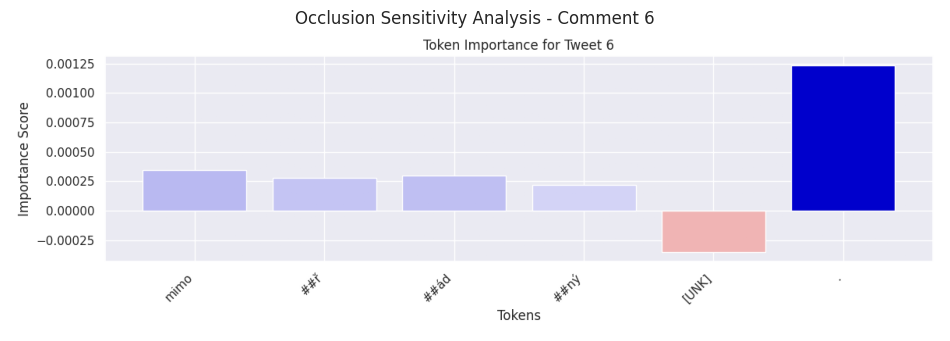

--------------------------------------------------------------------------------

Comment 7:
Text: Dobře mu nandal,bez ubrousků jasně.

Most influential tokens (Occlusion Sensitivity):
Empty DataFrame
Columns: [Token, Importance, Effect]
Index: []


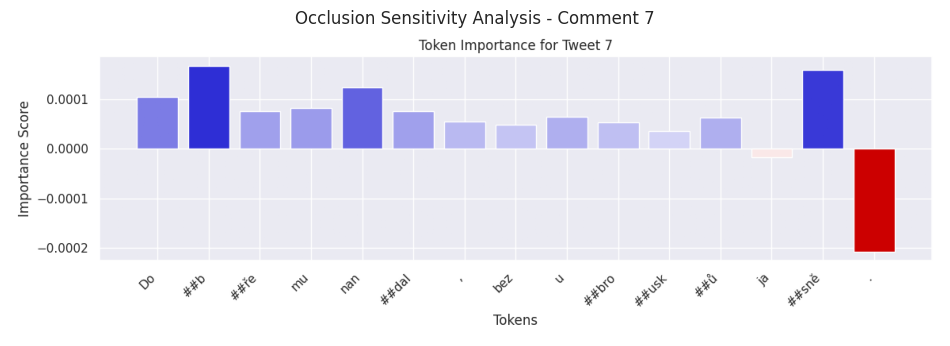

--------------------------------------------------------------------------------

Comment 8:
Text: mu dá,syčákovi.

Most influential tokens (Occlusion Sensitivity):
Empty DataFrame
Columns: [Token, Importance, Effect]
Index: []


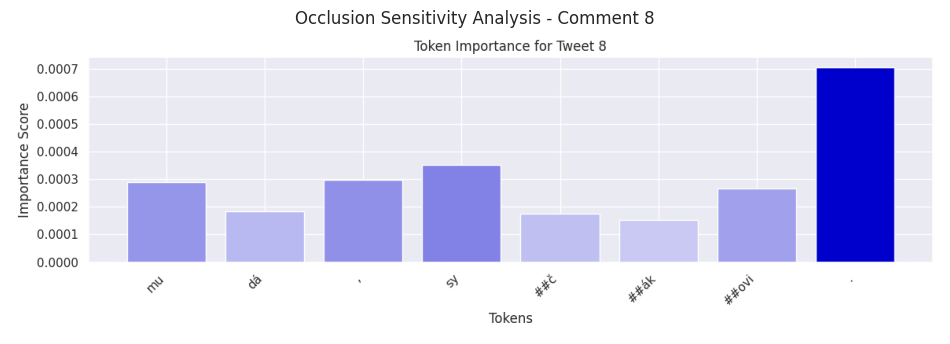

--------------------------------------------------------------------------------

Comment 9:
Text: Miroslav ZelenkaHm…ale dotáhl celkem slušně daleko..

Most influential tokens (Occlusion Sensitivity):
Empty DataFrame
Columns: [Token, Importance, Effect]
Index: []


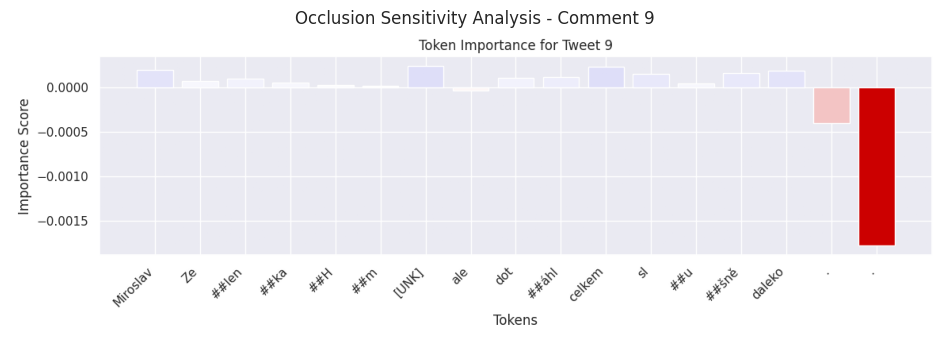

--------------------------------------------------------------------------------

Comment 10:
Text: Pávek?

Most influential tokens (Occlusion Sensitivity):
Empty DataFrame
Columns: [Token, Importance, Effect]
Index: []


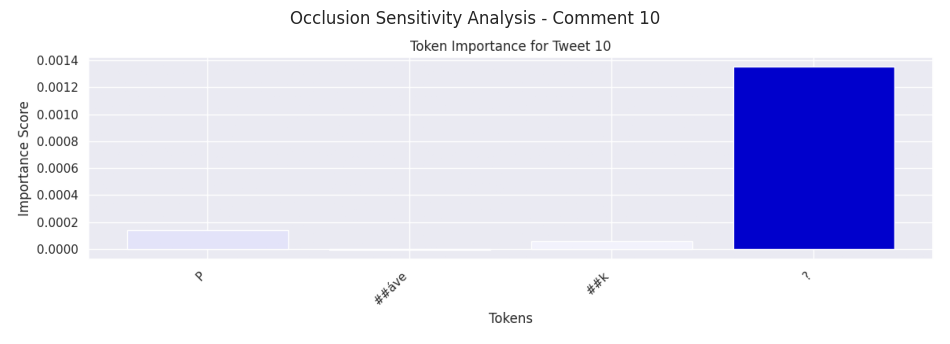

--------------------------------------------------------------------------------



Analyzing author: Michal Markó
Prediction confidence: 0.997
Troll probability: 0.997

=== Occlusion Sensitivity Analysis ===

Generating explanations using occlusion sensitivity...

Processing tweet 1/10
Occlusion analysis for Tweet 1:
Text: Ať Ukrajinci pomohou doma rou jiného státu
Plot saved to: importance_tweet_1.png
Top contributing tokens:

Processing tweet 2/10
Occlusion analysis for Tweet 2:
Text: SPD nemusz vydat volební kampaň korunu. Vládní koalice mu zaplatila.
Plot saved to: importance_tweet_2.png
Top contributing tokens:

Processing tweet 3/10
Occlusion analysis for Tweet 3:
Text: Větší blábol nečetl. živit.
Plot saved to: importance_tweet_3.png
Top contributing tokens:

Processing tweet 4/10
Occlusion analysis for Tweet 4:
Text: Václav SchwarzV pražské kavárně
Plot saved to: importance_tweet_4.png
Top contributing tokens:

Processing tweet 5/10
Occlusion analysis for Tweet 5:
Text: Jiří P

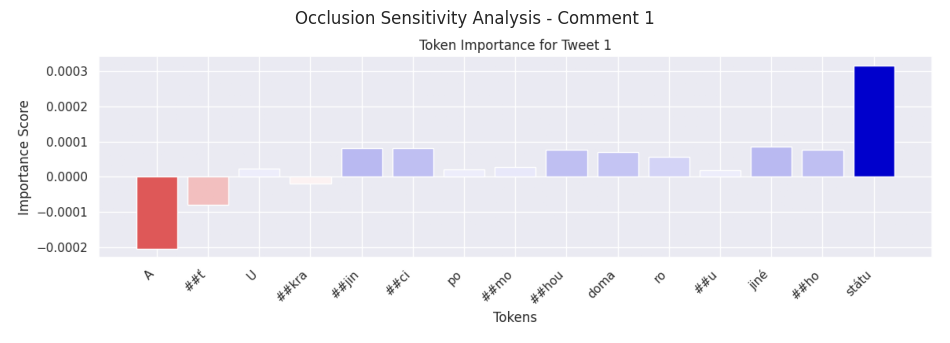

--------------------------------------------------------------------------------

Comment 2:
Text: SPD nemusz vydat volební kampaň korunu. Vládní koalice mu zaplatila.

Most influential tokens (Occlusion Sensitivity):
Empty DataFrame
Columns: [Token, Importance, Effect]
Index: []


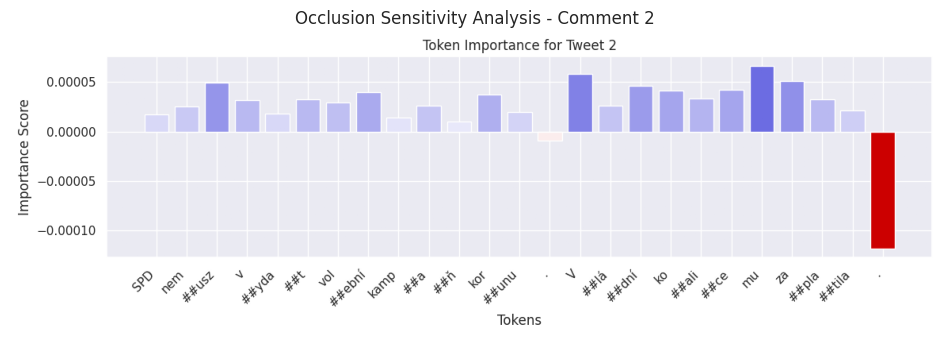

--------------------------------------------------------------------------------

Comment 3:
Text: Větší blábol nečetl. živit.

Most influential tokens (Occlusion Sensitivity):
Empty DataFrame
Columns: [Token, Importance, Effect]
Index: []


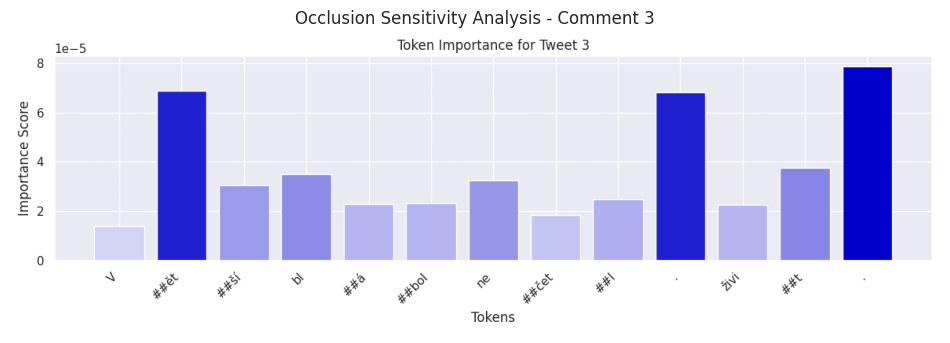

--------------------------------------------------------------------------------

Comment 4:
Text: Václav SchwarzV pražské kavárně

Most influential tokens (Occlusion Sensitivity):
Empty DataFrame
Columns: [Token, Importance, Effect]
Index: []


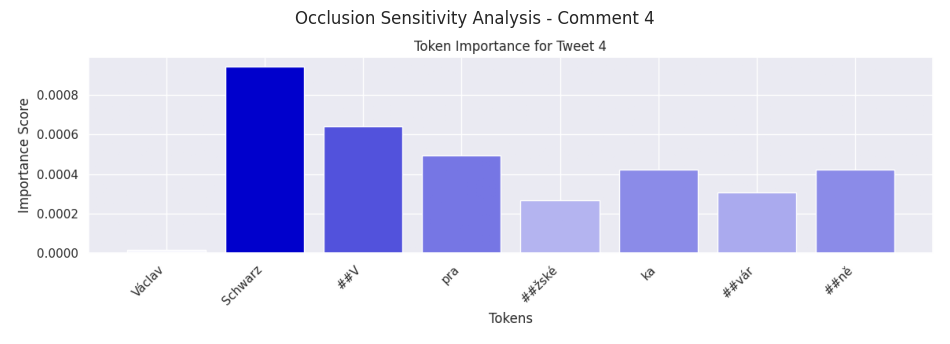

--------------------------------------------------------------------------------

Comment 5:
Text: Jiří PařízekHlavně, docenite Vy.

Most influential tokens (Occlusion Sensitivity):
Empty DataFrame
Columns: [Token, Importance, Effect]
Index: []


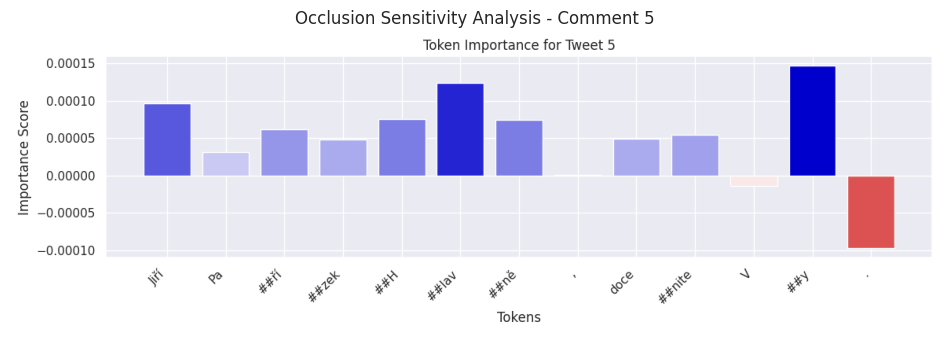

--------------------------------------------------------------------------------

Comment 6:
Text: divit. Konečná rozdíl Fiali hlavě srovnané neplácá nesmysly on.

Most influential tokens (Occlusion Sensitivity):
Empty DataFrame
Columns: [Token, Importance, Effect]
Index: []


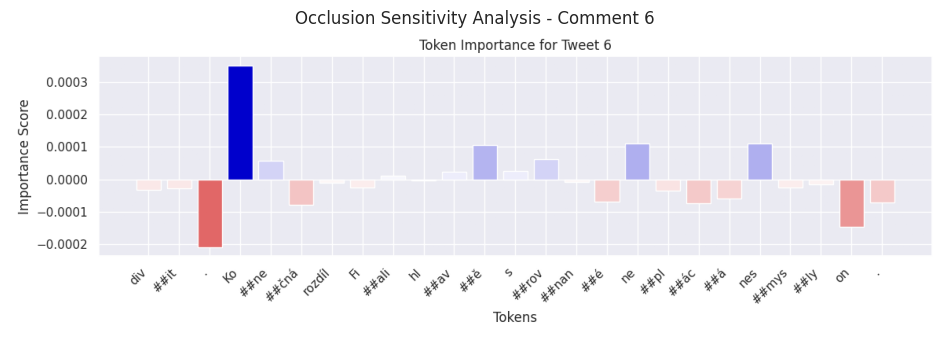

--------------------------------------------------------------------------------

Comment 7:
Text: Šikula ZbyněkŽelenský zas starý, mu Riki dědek

Most influential tokens (Occlusion Sensitivity):
Empty DataFrame
Columns: [Token, Importance, Effect]
Index: []


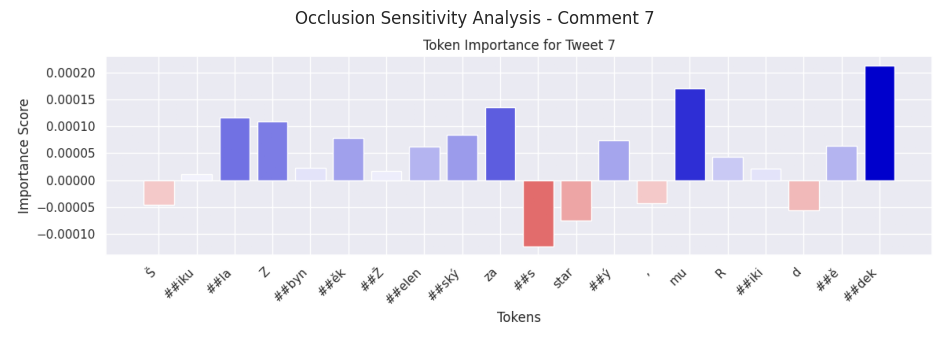

--------------------------------------------------------------------------------

Comment 8:
Text: vojně říkal velitel . platí politicích hlavně, blíží volby.

Most influential tokens (Occlusion Sensitivity):
Empty DataFrame
Columns: [Token, Importance, Effect]
Index: []


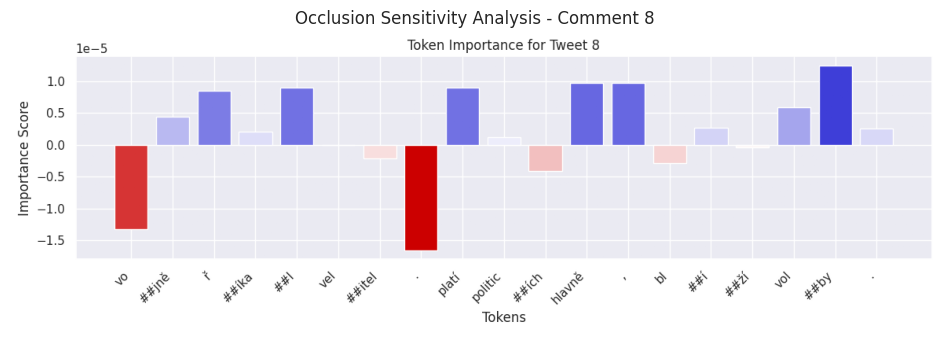

--------------------------------------------------------------------------------

Comment 9:
Text: Jakub TrenzVšeho času. důchodce.

Most influential tokens (Occlusion Sensitivity):
Empty DataFrame
Columns: [Token, Importance, Effect]
Index: []


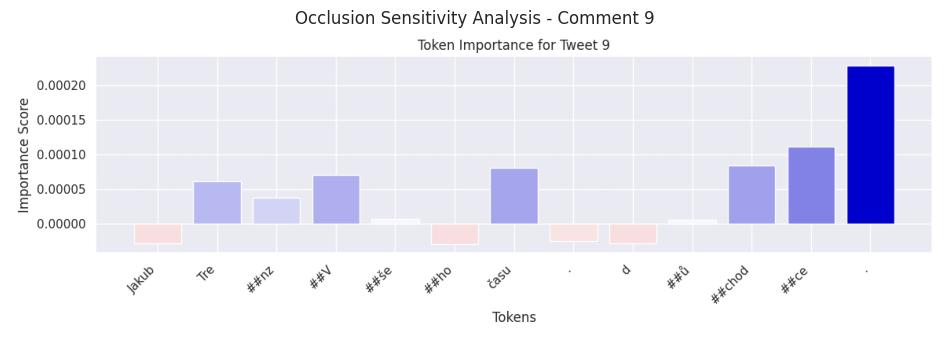

--------------------------------------------------------------------------------

Comment 10:
Text: brýlatý trotl žije mimo realitu.

Most influential tokens (Occlusion Sensitivity):
Empty DataFrame
Columns: [Token, Importance, Effect]
Index: []


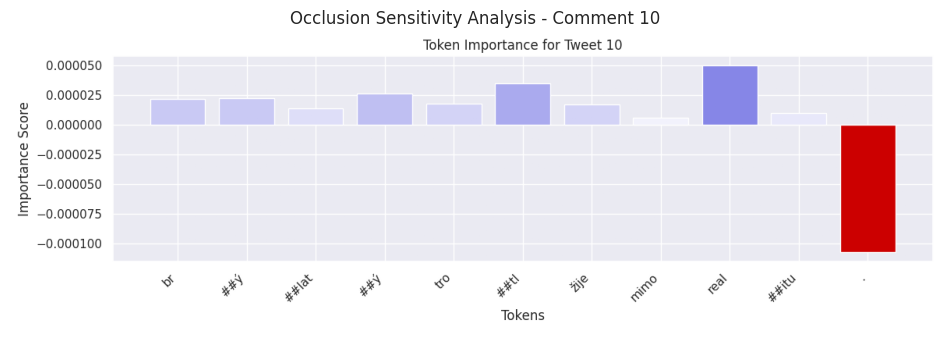

--------------------------------------------------------------------------------




In [19]:
# Example usage
# authors_to_explain = [
#     "Jitka Bártová",
#     "Roman Myška",   
# ]
authors_to_explain = [
    "Vladimír Furrer",
    "Michal Markó",   
]


for author in authors_to_explain:
    explain_author(
        author_name=author,
        predictor_instance=predictor,
        comments_df=czech_comments,
        display_plots=True,
    )
    print("\n" + "="*80 + "\n")